# Horse or Human?
---
The goal of this project is to use augmented data to build a classifier to detect horse or humans. 

Often, when working with image data to build models, we find the same images over and over again. Collecting good quality images of a particular subject requires a lot of work. Instead, this experiment aims to find weather we can create a model that can classify images based on rendered images. This would enable us to create a near infinite amount of training data on virtually any subject in a relatively streamlined and easy process. 

The model uses a pretrained base under a simple head as well as over 1000 rendered images of horses and humans in an attempy to successfully classify them. 

More informaiton about the dataset can be found here: https://www.kaggle.com/sanikamal/horses-or-humans-dataset

---

In [1]:
#Import Statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import RMSprop

import os

In [2]:
#Define Paths
train_dir = '../input/horses-or-humans-dataset/horse-or-human/train/'
train_dir_horses = '../input/horses-or-humans-dataset/horse-or-human/train/horses/'
train_dir_humans = '../input/horses-or-humans-dataset/horse-or-human/train/humans/'

val_dir = '../input/horses-or-humans-dataset/horse-or-human/validation/'
val_dir_horses = '../input/horses-or-humans-dataset/horse-or-human/validation/horses/'
val_dir_humans = '../input/horses-or-humans-dataset/horse-or-human/validation/humans/'

#Get total number of training and validation images
print('Total number of training horse images: ',len(os.listdir(train_dir_horses)))
print('Total number of training human images: ',len(os.listdir(train_dir_humans)))
print('Total number of training images: ',len(os.listdir(train_dir_humans)) + len(os.listdir(train_dir_horses)))
print('\n')
print('Total number of validation horse images: ',len(os.listdir(val_dir_horses)))
print('Total number of validation human images: ',len(os.listdir(val_dir_humans)))
print('Total number of validation images: ',len(os.listdir(val_dir_humans)) + len(os.listdir(val_dir_horses)))

Total number of training horse images:  500
Total number of training human images:  527
Total number of training images:  1027


Total number of validation horse images:  128
Total number of validation human images:  128
Total number of validation images:  256


## Data Prep

---
Here, we use a generator to convert all the images into an array format. We do this to enable our Neural Netowrk to process the data. We also use augmentation during this step to artifically increase the number of images we have to train our model. Furthermore, we also divide all the pixel values of our images by 255 in order to standardize our data between 0 and 1.

In an image, each pixel is represented by a number between 0 and 255 corresponding to its intensity. By dividing by this number, we ensure that all the data lies between 0 and 1 to make it easier for our Neural Network to work with the data. Smaller numbers will ensure a faster overall process.



---

In [7]:
#Creating Traing and validation generators along with standardization and augmentation
train_generator = ImageDataGenerator(1./255, 
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True) #We augment the training data in various ways. 

val_generator = ImageDataGenerator(1./255) #We dont want to augment the validation data. We leave the data as is. 

#Batch Generators
train_batch_gen = train_generator.flow_from_directory(train_dir,
                                                target_size = (150,150),
                                                batch_size = 20,
                                                class_mode = 'binary')

val_batch_gen = val_generator.flow_from_directory(val_dir,
                                                 target_size = (150,150),
                                                 batch_size = 20,
                                                 class_mode = 'binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Model Creation

---
We use two models here: Xception and VGG16. Most solutions to this dataset use VGG16, but i was curious to know weather Xception could outperform it. This would be the first time I am persoanlly using an Xception base as well, which helps further scratch my curiosity itch. 

We use a learning rate reduction callback in order to make sure our model performs optimally. 

---

In [8]:
#Learning Rate Reduction callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

In [9]:
#Loading base
xception_base = Xception(include_top = False,
                         weights="imagenet",
                         input_shape=(150,150,3)
                        )
xception_base.trainable = True #Make base trainable.

vgg16_base = VGG16(include_top = False,
                   weights="imagenet",
                   input_shape=(150,150,3)
                  )
vgg16_base.trainable = False #Base is not trainable in this case. 

In [10]:
#Creating Model
model = keras.Sequential([
    xception_base,
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

#Compiling model
model.compile(optimizer = RMSprop(lr = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

#Fit model
history = model.fit_generator(train_batch_gen,
                    epochs = 30,
                    steps_per_epoch = 50,
                    validation_data = val_batch_gen,
                    validation_steps = 12,
                    callbacks = [learning_rate_reduction]
         
)
#Consider adding an early stopping callback as well in order to prevent overfitting and save on those precious GPU usage minutes.

Epoch 1/30
50/50 [==============================] - 31s 393ms/step - loss: 0.4713 - accuracy: 0.7648 - val_loss: 0.3003 - val_accuracy: 0.8792
Epoch 2/30
50/50 [==============================] - 13s 258ms/step - loss: 0.1130 - accuracy: 0.9598 - val_loss: 0.0264 - val_accuracy: 1.0000
Epoch 3/30
50/50 [==============================] - 13s 261ms/step - loss: 0.0728 - accuracy: 0.9751 - val_loss: 0.0331 - val_accuracy: 0.9958
Epoch 4/30
50/50 [==============================] - 13s 253ms/step - loss: 0.0300 - accuracy: 0.9917 - val_loss: 0.0967 - val_accuracy: 0.9583
Epoch 5/30
50/50 [==============================] - 13s 250ms/step - loss: 0.0420 - accuracy: 0.9881 - val_loss: 0.1156 - val_accuracy: 0.9500

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 6/30
50/50 [==============================] - 13s 259ms/step - loss: 0.0116 - accuracy: 0.9985 - val_loss: 0.0936 - val_accuracy: 0.9542
Epoch 7/30
50/50 [==============================] - 13s 252ms

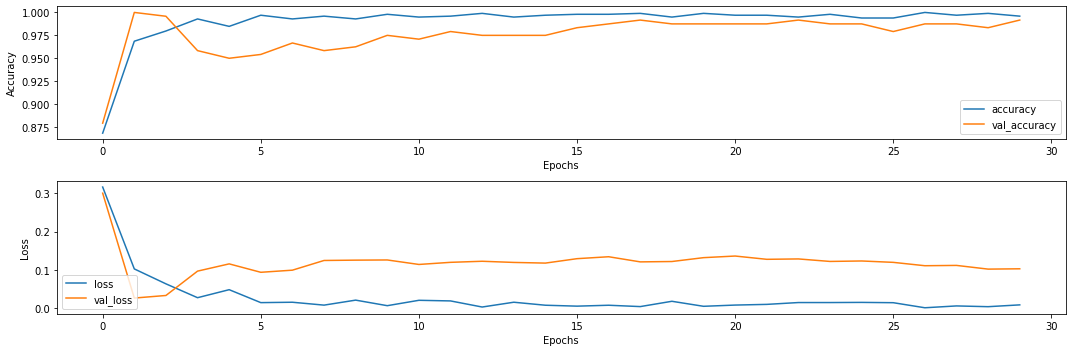

In [11]:
#Plotting the results
plt.figure(figsize = (15,5))

plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
# plt.yticks(np.linspace(0.96,0.995))

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='lower left')


plt.tight_layout()
plt.show()

In [12]:
#Second model - VGG16
#Creating Model
model2 = keras.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

#Compiling model
model2.compile(optimizer = RMSprop(lr = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['binary_accuracy'])

#Fit model
history2 = model.fit_generator(train_batch_gen,
                    epochs = 30,
                    steps_per_epoch = 50,
                    validation_data = val_batch_gen,
                    validation_steps = 12,
                    callbacks = [learning_rate_reduction]
         
)

Epoch 1/30
50/50 [==============================] - 13s 255ms/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 0.1082 - val_accuracy: 0.9875
Epoch 2/30
50/50 [==============================] - 13s 255ms/step - loss: 0.0054 - accuracy: 0.9959 - val_loss: 0.1081 - val_accuracy: 0.9875
Epoch 3/30
50/50 [==============================] - 13s 249ms/step - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.1031 - val_accuracy: 0.9875
Epoch 4/30
50/50 [==============================] - 13s 257ms/step - loss: 0.0184 - accuracy: 0.9939 - val_loss: 0.1064 - val_accuracy: 0.9875
Epoch 5/30
50/50 [==============================] - 12s 248ms/step - loss: 0.0046 - accuracy: 0.9970 - val_loss: 0.1022 - val_accuracy: 0.9833
Epoch 6/30
50/50 [==============================] - 12s 248ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.0921 - val_accuracy: 0.9875
Epoch 7/30
50/50 [==============================] - 13s 256ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0939 - val_accuracy: 0.9875

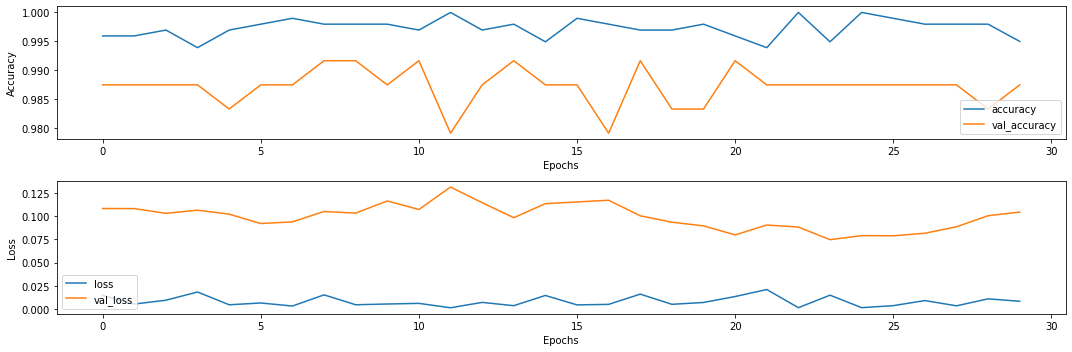

In [13]:
#Plotting the results
plt.figure(figsize = (15,5))

plt.subplot(2, 1, 1)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
# plt.yticks(np.linspace(0.96,0.995))

plt.subplot(2, 1, 2)
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='lower left')


plt.tight_layout()
plt.show()

---
Both Xception and VGG16 perform exceptionally well, with Xception doing just slightly better. With slightly better tuning and a more an early stopping callback function we should might be able to squeeze out slightly better performace as well. The extra perfomace might also be attributed to the fact that we allowed the base to be trained. Ordinarily, you dont want to train the base without first also training the head because the random, unoptized weights of the head would cause the pretrained base to completely change its weights, however, in this scenario, I believe it is okay becuase we are using an optimizer with an extremely small learning rate to being with (RMSprop @ 2e-5)

Thank you for reading my notebook!    
If you have any questions about the notebook or any methods used within, please let me know! 

Referenced notebooks:    
https://www.kaggle.com/luukhang/horses-vs-humans-pretrained-vgg16    
https://www.kaggle.com/shravanraikar/computer-vision-using-tensorflow-vgg16    

---